In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy as sp
import matplotlib.pyplot as plt
from download import download

np.set_printoptions(suppress=True)

In [2]:
OBS = 100 # observation period
EXT = 20 # extrapolation period
EPOCH = 1000 # number of simulations

In [3]:
ticker = input("Ticker: ")
apikey = open("apikey", "r").readline()
raw = download(ticker, apikey)
print(raw)

Ticker: SPLG
            date   adjClose
0     2005-11-15  10.151241
1     2005-11-16  10.085182
2     2005-11-17  10.085182
3     2005-11-18  10.219082
4     2005-11-21  10.260143
...          ...        ...
4464  2023-08-14  52.710000
4465  2023-08-15  52.100000
4466  2023-08-16  51.680000
4467  2023-08-17  51.310000
4468  2023-08-18  51.340000

[4469 rows x 2 columns]


SPLG P&L
                 0
count  4468.000000
mean      0.000433
std       0.011842
min      -0.116761
25%      -0.003910
50%       0.000155
75%       0.005495
max       0.095256


[Text(0.5, 0, 'SPLG P&L'), Text(0, 0.5, 'Frequency')]

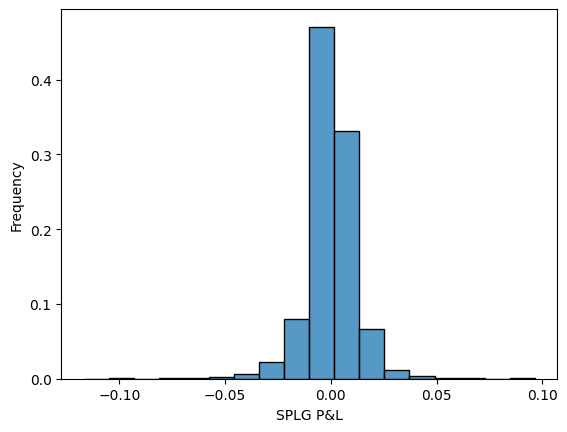

In [4]:
t0 = np.array(raw["adjClose"][0:-1])
t1 = np.array(raw["adjClose"][1:])
returns = (t1 - t0) / t0

returns = np.array(returns)
raw = raw.iloc[1:]

print("{} P&L" .format(ticker))
print(pd.DataFrame(returns).describe())

ax = sns.histplot(data=returns, binwidth=np.std(returns), stat="probability")
ax.set(xlabel="{} P&L" .format(ticker), ylabel="Frequency")

In [5]:
valuation_series = []
recent_simulations = []

In [6]:
for T in range(OBS-1, raw.shape[0]):
    s0 = raw["adjClose"][T] # current value
    mu = returns[T+1-OBS:T+1].mean() # mean daily return
    sigma = np.std(returns[T+1-OBS:T+1]) # variability in daily returns
    drift = mu + 0.5 * sigma**2 # drift of random walk
    
    brownian = np.random.normal(0, 1, (EPOCH, EXT)) # brownian shock values
    brownian = np.cumsum(brownian, axis=1)
    
    t = np.arange(1, EXT+1) # extrapolation time
    path = s0 * np.exp(drift * t + sigma * brownian) # simulated paths
    
    # P(s_t > s0 | t E {1, 2, 3, ... , EXT}) (valuation score)
    score = float(sum(path.flatten() > s0)) / (EPOCH * EXT)
    valuation_series.append(score)
    
    if T == raw.shape[0] - 1: # save recent simulations
        recent_simulations = np.insert(path, 0, s0, axis=1)
    
    #print("T={} @ {} VAL={}" .format(T, ticker, score))

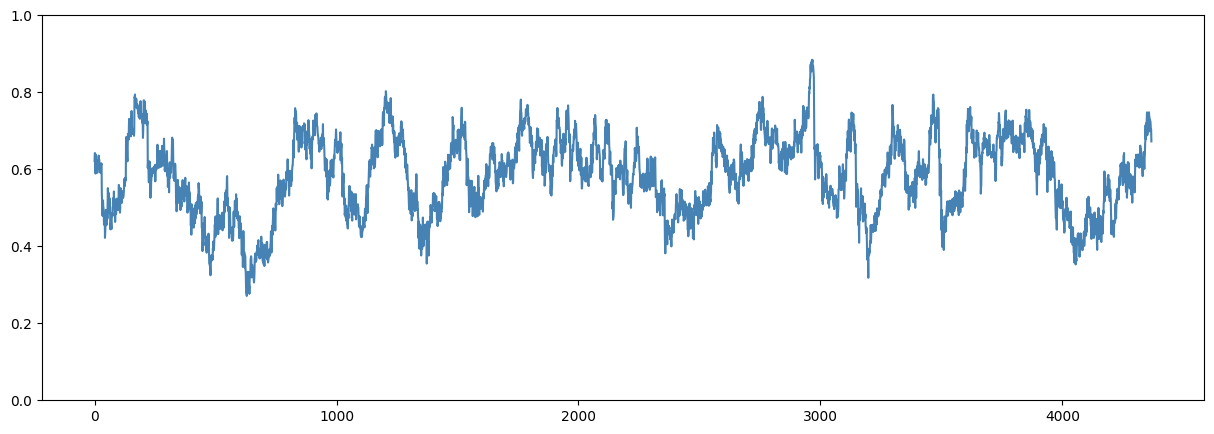

In [7]:
plt.figure(figsize=(15,5))
plt.plot(valuation_series, color="steelblue", label="valuation")
plt.ylim(0, 1)
plt.show()

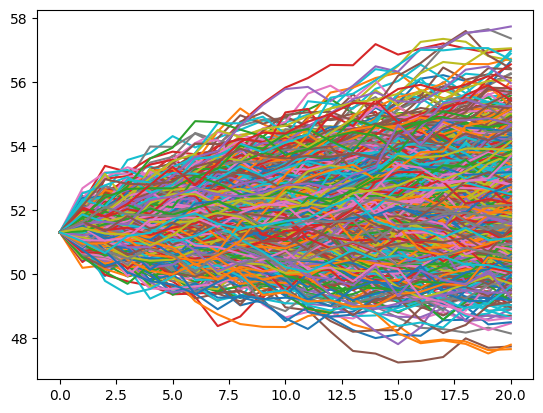

In [8]:
for path in recent_simulations:
    plt.plot(path)
plt.show()